In [6]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_hex
import matplotlib.gridspec as gridspec
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
sc = SparkSession.builder.getOrCreate()

# Company revenue clustering analysis

The goal of this analysis is to find patterns in the amount of money users spend through the use of clustering algorithms in Spark. We start by loading all necessary data for the clustering algorithm, engineering all necessary dataframes and finally merging into the final dataframe to be used in the cluster algorithm.

In [7]:
buyclicksDF = (  # How much each user has spent on the game
    pd.read_csv('./data/buy-clicks.csv')[['userId', 'price']]
    .groupby('userId')
    .sum()
    .reset_index()
    .rename(columns={'price': 'userSpending'})
)
buyclicksDF.head(n=3)

,userId,userSpending
0,1,21.0
1,8,53.0
2,9,80.0


In [8]:
gameclicksDF = (  # The hit accuracy of the user
    pd.read_csv('./data/game-clicks.csv')[["userId", "isHit"]]
    .groupby("userId")
    .mean()
    .rename(columns={"isHit": "hitAverage"})
    .reset_index()
)
gameclicksDF.head(n=3)

,userId,hitAverage
0,0,0.105535
1,1,0.134078
2,2,0.095238


In [9]:
adclicksDF = pd.read_csv('./data/ad-clicks.csv')[["userId", "adCategory"]]
adclicksDF['adCount'] = 1  # Accumulator for an ad click
adclicksDF = (  # How much each user has clicked on an ad
    adclicksDF
    .groupby('userId')
    .sum()
    .reset_index()
    .drop(columns=["adCategory"])
)
adclicksDF.head(n=3)

,userId,adCount
0,1,44
1,8,10
2,9,37


In [10]:
teamlevelDF = (  # User's team and team level
    pd.read_csv('./data/user-session.csv')[["userId", "teamId", "teamLevel"]]
    .groupby(["userId", "teamId"])
    .max()
    .reset_index()
    .sort_values(by=["userId", "teamLevel"], ascending=[True, False])
    .drop_duplicates(subset='userId', keep="first")
)
teamlevelDF.head(n=3)

,userId,teamId,teamLevel
0,0,157,4
1,1,99,7
2,2,22,7


In [11]:
teamstrengthDF = (
    pd.read_csv('./data/team.csv')[["teamId", "strength"]]
    .rename(columns={'strength': 'teamStrength'})
)
teamstrengthDF.head(n=3)

,teamId,teamStrength
0,79,0.774474
1,92,0.171926
2,6,0.537353


In [12]:
usersessionDF = (
    pd.get_dummies(  # Create cols for logins per platform
        pd.read_csv('./data/user-session.csv')[["userId", "platformType"]],
        columns=['platformType']
    )
    .groupby('userId')
    .sum()
    .reset_index()
)
usersessionDF.head(n=3)

,userId,platformType_android,platformType_iphone,platformType_linux,platformType_mac,platformType_windows
0,0,0,8,0,0,0
1,1,14,0,0,0,0
2,2,0,10,0,0,0


In [13]:
combinedDF = (
    buyclicksDF
    .merge(gameclicksDF, on="userId")
    .merge(adclicksDF, on="userId")
    .merge(teamlevelDF, on="userId")
    .merge(teamstrengthDF, on="teamId")
    .merge(usersessionDF, on="userId")
    .drop(columns=["userId", "teamId"])
)
combinedDF.head(n=3)

,userSpending,hitAverage,adCount,teamLevel,teamStrength,platformType_android,platformType_iphone,platformType_linux,platformType_mac,platformType_windows
0,21.0,0.134078,44,7,0.893054,14,0,0,0,0
1,80.0,0.122047,37,7,0.340788,0,12,0,0,0
2,215.0,0.130682,46,7,0.343485,0,14,0,0,0


We define the K-Means algorithm in a function, so that we can recalculate the values with different parameters and observe the changes

In [14]:
def calculate_kmeans(num_centers: int) -> tuple:
    assembler = VectorAssembler(inputCols=combinedDF.columns.to_list(), outputCol="features")
    assembled = assembler.transform(sc.createDataFrame(combinedDF))
    kmeans = KMeans(k=num_centers, featuresCol="features", seed=1, maxIter=99)
    model = kmeans.fit(assembled)
    centers = sorted(model.clusterCenters(), key=lambda x: x[0])
    predictions = model.transform(assembled)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    cmap = LinearSegmentedColormap.from_list(
        "my_colormap", ["red", "yellow", "green"], N=num_centers)
    colors = [to_hex(color) for color in cmap(range(num_centers))]
    return centers, predictions, colors, score
feature_means = combinedDF.mean(axis=0)
feature_means

userSpending            46.696884
hitAverage               0.115536
adCount                 35.039660
teamLevel                6.957507
teamStrength             0.511562
platformType_android     3.603399
platformType_iphone      4.192635
platformType_linux       0.634561
platformType_mac         0.300283
platformType_windows     1.450425
dtype: float64

We define the plotting function to observe the results of the model

In [15]:
def plot_results(num_clusters):
    centers, predictions, colors, score = calculate_kmeans(num_clusters)
    plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 5)

    for i, feature in enumerate(combinedDF.columns):
        ax = plt.subplot(gs[i])
        x = [str(c) for c in range(len(centers))]
        y = [centers[c][i] for c in range(len(centers))]
        ax.set_title(feature)
        ax.bar(x, y, color=colors, edgecolor="black")
        ax.axhline(y=feature_means.iloc[i], linestyle="--")
    title = "Feature comparisons per cluster with mean baseline, "
    title += f"Silhouette score = {round(score*100, 2)}%"
    plt.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.show()

Before we can see the results, it is important to evaluate the performance of the model with different numbers of clusters

In [16]:
max_clusters = 15
for num_clusters in range(2, max_clusters + 1):
    _, _, _, score = calculate_kmeans(num_clusters)
    print(
        f"Clusters: {num_clusters},",
        f"score: {round(score * 100, 3)}%"
    )

24/04/30 00:30:34 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Clusters: 2, score: 80.296%
Clusters: 3, score: 68.724%
Clusters: 4, score: 55.093%
Clusters: 5, score: 55.047%
Clusters: 6, score: 52.602%
Clusters: 7, score: 52.279%
Clusters: 8, score: 50.954%
Clusters: 9, score: 50.95%
Clusters: 10, score: 46.641%
Clusters: 11, score: 45.895%
Clusters: 12, score: 45.203%
Clusters: 13, score: 47.827%
Clusters: 14, score: 49.928%
Clusters: 15, score: 47.616%


Now we can plot the cluster features and compare them to each other. A horizontal bar was added to indicate the median value of the feature from the dataframe used to train the model. You may adjust the number of clusters in the `plot_results()` function and see how the centers change.

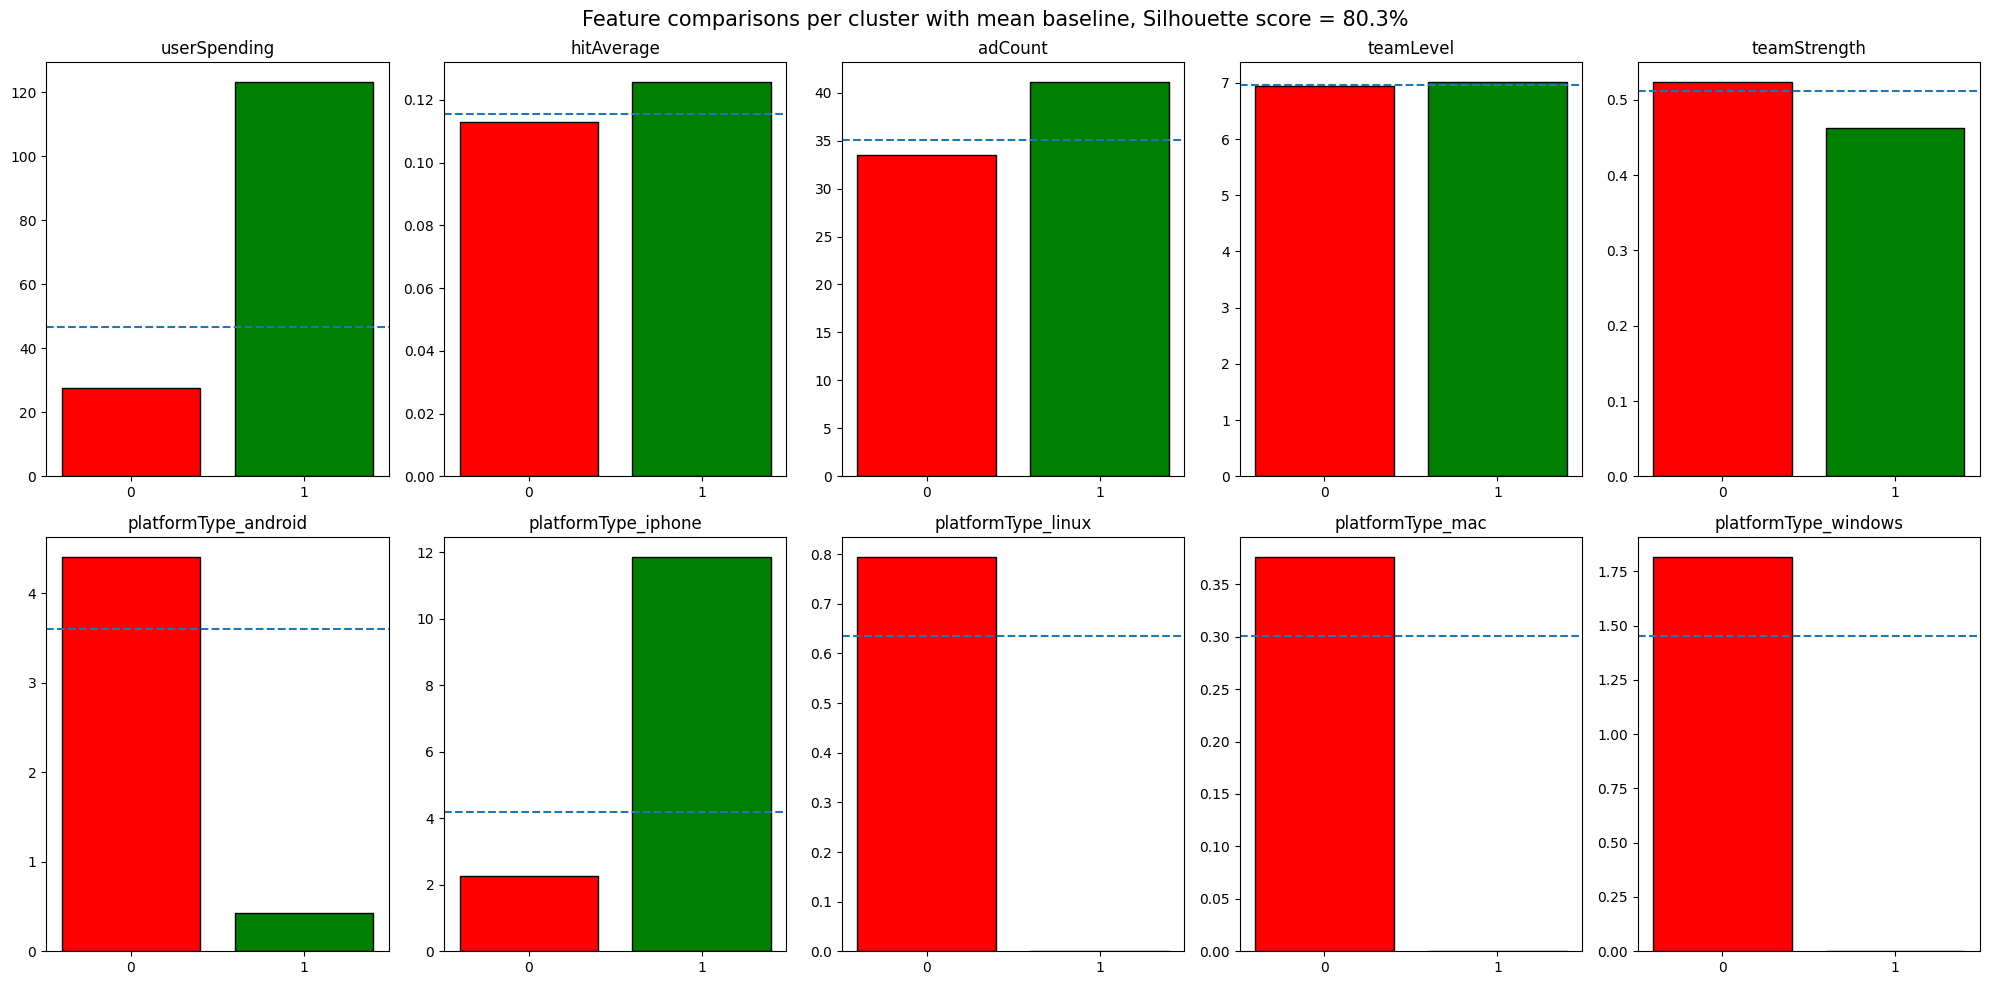

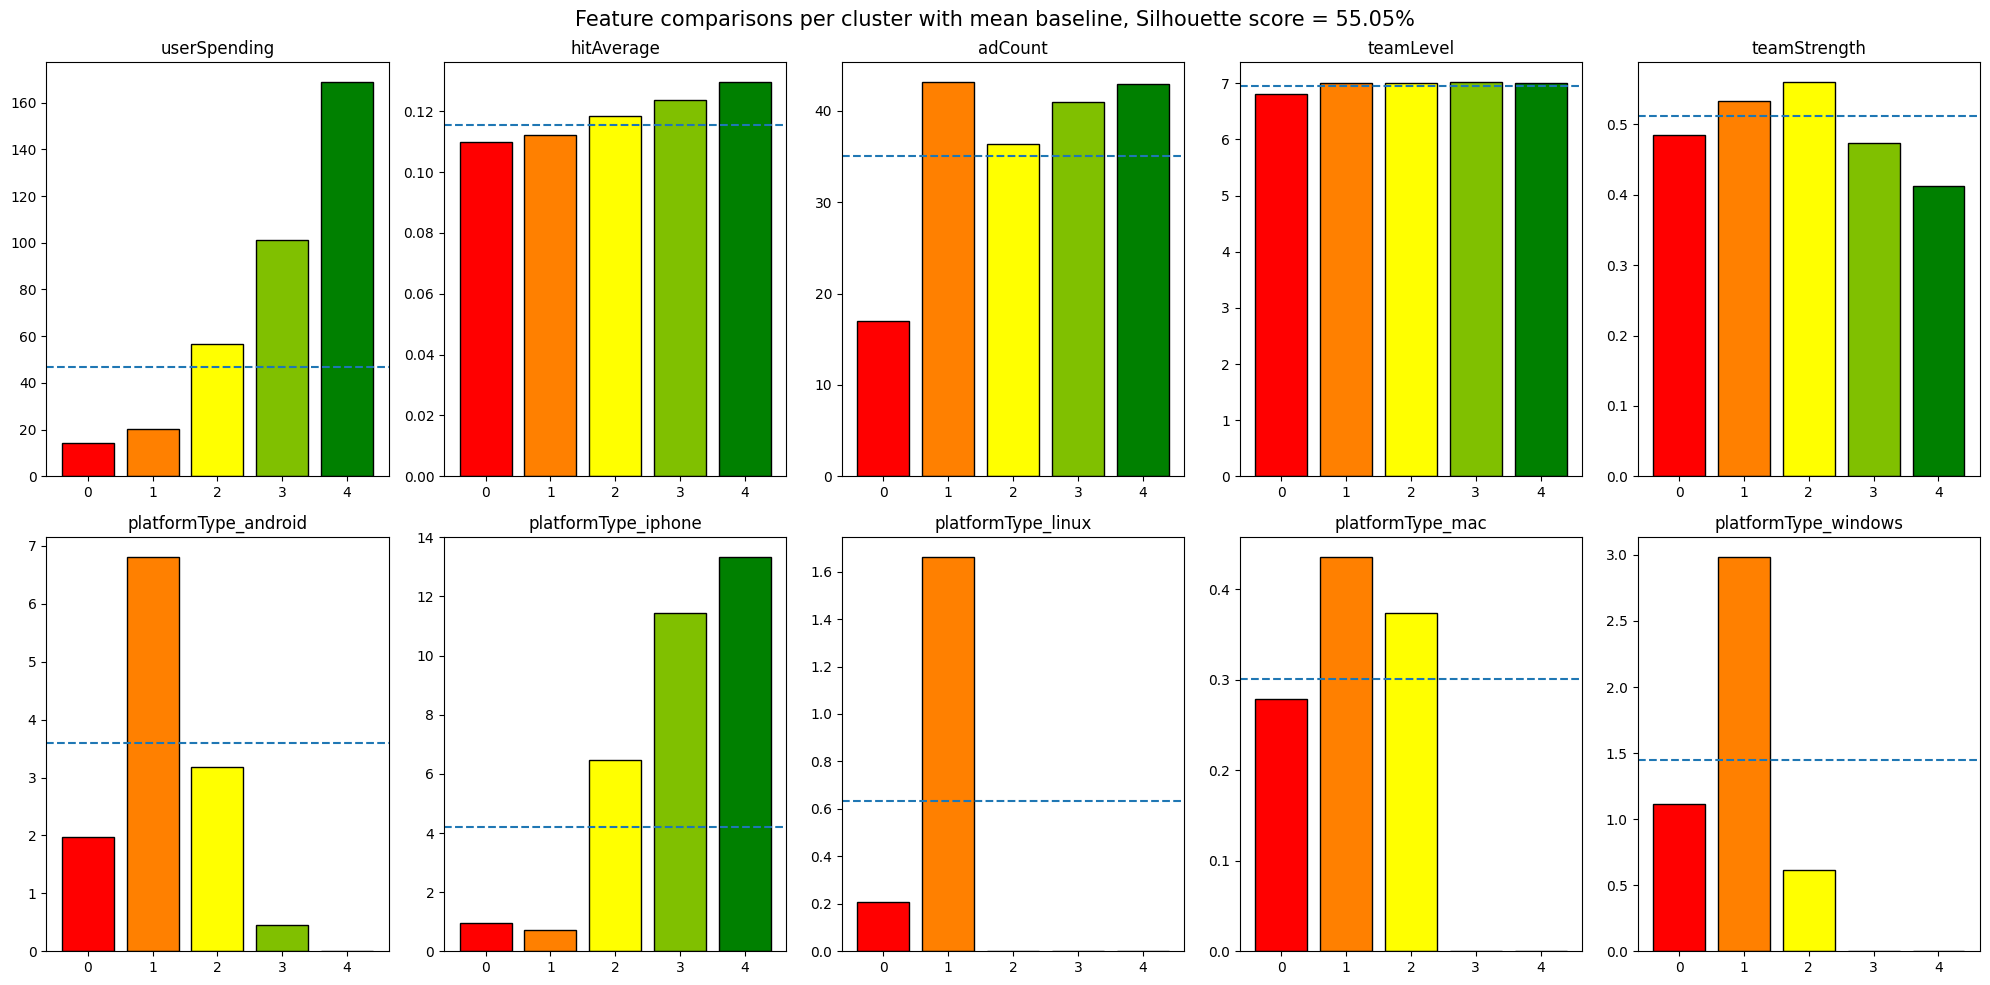

In [17]:
plot_results(2)
plot_results(5)